In [1]:
import sys
import json
import pickle
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
from PIL import Image
import math
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf
torch.set_grad_enabled(False)

sys.path.append('../')
from models.library import qres34m

In [2]:
weights_root = Path('../checkpoints/qres34m')
# save_json_path = '../results/kodak-qres34m.json'

# initialize model
lmb = 2048
model = qres34m(lmb=lmb)
wpath = weights_root / f'lmb{lmb}/last_ema.pt'
msd = torch.load(wpath)['model']
model.load_state_dict(msd)

# model.compress_mode()
model = model.cuda()
model.eval()
print(f'Using lmb={lmb}. Model weights={wpath}')


Using lmb=2048. Model weights=..\checkpoints\qres34m\lmb2048\last_ema.pt


In [3]:
dataset_root = 'd:/datasets/improcessing/kodak'


single_model_bpps  = defaultdict(float)
single_model_psnr = defaultdict(float)
# for keep in range(13):

device = next(model.parameters()).device
img_paths = list(Path(dataset_root).rglob('*.*'))
for impath in tqdm(img_paths):
    # read image
    im = tvf.to_tensor(Image.open(impath)).unsqueeze_(0).to(device=device)
    _, imC, imH, imW = im.shape
    # compression
    # compressed_obj = model.compress(im)
    stats_all = model.forward_get_latents(im)

    L = len(stats_all)
    for keep in range(1, L+1):
    # for keep in [L]:
        # keep only a subset of latents
        latents = [stat['z'] if (i < keep) else None for (i,stat) in enumerate(stats_all)]
        # compute bpp
        kl_divs = [stat['kl'] for (i,stat) in enumerate(stats_all) if (i < keep)]
        bpp = sum([kl.sum(dim=(1,2,3)) for kl in kl_divs]) / (imH * imW) * math.log2(math.e)
        # print(bpp, type(bpp))
        cond_sample = model.cond_sample(latents, temprature=0)
        # print(f'Keep={keep}, bpp={kl.item()}')
        mse = torch.nn.functional.mse_loss(im, cond_sample, reduction='mean')
        psnr = -10.0 * math.log10(mse.item())
        # print(bpp.item(), mse.item())

        single_model_bpps[keep] += float(bpp)
        single_model_psnr[keep] += psnr
    # print('debug'); break

# sort the R-D stats
keys = list(single_model_bpps.keys())
keys.sort()
# average psnr and bpp over all images
count = float(len(img_paths))
single_model_bpps  = [single_model_bpps[k] /count for k in keys]
single_model_psnr = [single_model_psnr[k]/count for k in keys]

debug = 1

100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


In [4]:
results_path = Path().cwd() / '../results/kodak-qres34m.json'
with open(results_path, 'r') as f:
    results_qres34m = json.load(f)

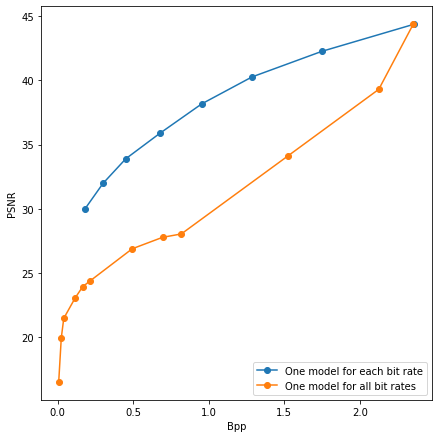

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
l1 = plt.plot(results_qres34m['bpp'], results_qres34m['psnr'],
              label=f'One model for each bit rate', marker='.', markersize=12)
l1 = plt.plot(single_model_bpps, single_model_psnr,
              label=f'One model for all bit rates', marker='.', markersize=12)
# l2 = plt.plot(psnr2, lr2, label=f'PSNR-logBPP {name2}',
#                 marker='.', markersize=12, linestyle='None')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.xlim(np.concatenate([psnr1,psnr2]).min()-1, np.concatenate([psnr1,psnr2]).max()+1)
# plt.ylim(np.concatenate([lr1, lr2]).min()-0.1, np.concatenate([lr1, lr2]).max()+0.1)
plt.xlabel('Bpp')
plt.ylabel('PSNR')
plt.show()